# Sentiment Analysis - Customer Reviews

This project is an abridged version of an exciting NLP project I did with a real client as an AI/ML Consulting intern at Qrious over the 2021/2022 summer!

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import textblob
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

C:\Users\nicho\AppData\Local\Temp\ipykernel_54640\1318859184.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
# only need to run once to download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

## Data Acquisition

For the ski fields (both of the client's and of the competitor's they were interested in) in question, the most number of reviews were found on TripAdvisor, Facebook, and Google Reviews. Reviews from other websites like Yelp and Expedia were very sparse or not publicly accessible.

A combination of simple GUI-based workflows using publicly-available web scraping software and Selenium/BeautifulSoup scripts were used to collect reviews from those three sources. Extra care was taken to ensure any personally identifiable information (name, age etc.) and only the relevant information (the review text the date of the review, and any other quantitative review information e.g. scores given out of 5) were acquired.

## Data Preprocessing

### Dates

Since different review websites presented the review data differently (day/month/year, ## months/years ago etc.), the decision was made to transform any date information into two separate columns of information, one for the month that the review was posted and one for the year it was posted. This could potentially allow us to explore any seasonal changes in the sentiment of reviews.

Luckily, TripAdvisor and Facebook already present reviews with separate HTML fields for the review date and review year, so parsing these was straightforward. In Google Reviews however, the date of the review is presented relative to the date that a user accessed that review - a sample of those reviews are shown below.

In [70]:
sample_df = pd.read_csv('google-reviews-sample.csv')
sample_df.head(10)

,review_text,review_date
0,Facilities are top standard and clean. Chair l...,4 months ago
1,Stay away,a year ago
2,Free bus shuttle in the morning and from 1:30 ...,2 months ago
3,yeah do big ski jump,9 months ago
4,Went up on the Chondola sightseeing and had so...,4 months ago
5,After skiing in countries such as Japan and Au...,a month ago
6,"Great ski field, staff are friendly!",a year ago
7,"Rental process was a cinch, staff are great, h...",4 months ago
8,Fun skiing beautiful snow and a good amount fo...,a month ago
9,"Busy, busy, busy and busy. Welcome to Crowdron...",3 months ago


To convert the relative review dates (as shown above) into absolute dates, regex matching was considered. However, it was determined that the same could be achieved in a simpler way by simply parsing the review_date string.

In [71]:
def parse_relative_date(date_str, current_date=None):
    if current_date is None:
        current_date = pd.to_datetime('today')
    num, unit, _ = date_str.split()
    n = 1 if num=='a' else int(num)
    if 'month' in unit:
        abs_review_date = current_date - pd.DateOffset(months=n)
    elif 'year' in unit:
        abs_review_date = current_date - pd.DateOffset(years=n)
    month = abs_review_date.month_name()
    year = abs_review_date.year
    return month, year

In [72]:
sample_df[['review_month', 'review_year']] = sample_df['review_date'].apply(
    lambda x: pd.Series(parse_relative_date(x, current_date=pd.to_datetime('7/1/2022')))
    )
cleaned_sample_df = sample_df[['review_year', 'review_month', 'review_text']]
cleaned_sample_df.head(10)

,review_year,review_month,review_text
0,2022,March,Facilities are top standard and clean. Chair l...
1,2021,July,Stay away
2,2022,May,Free bus shuttle in the morning and from 1:30 ...
3,2021,October,yeah do big ski jump
4,2022,March,Went up on the Chondola sightseeing and had so...
5,2022,June,After skiing in countries such as Japan and Au...
6,2021,July,"Great ski field, staff are friendly!"
7,2022,March,"Rental process was a cinch, staff are great, h..."
8,2022,June,Fun skiing beautiful snow and a good amount fo...
9,2022,April,"Busy, busy, busy and busy. Welcome to Crowdron..."


In [73]:
cleaned_sample_df.to_csv('cleaned-google-reviews-sample.csv', index=False)

A limitation of this method is that reviews that were posted a year ago are assumed to have been posted in the same month that the reviews were parsed - further work could utilise the metadata for each review to find the exact month.

After parsing dates, reviews across Facebook. TripAdvisor, and Google for three different ski fields (named "field_1", "field_2", and "field_3" for simplicity) were collated into three individual CSV files, as shown below.

In [132]:
df1 = pd.read_csv('all-reviews-sample-field-1.csv')
df2 = pd.read_csv('all-reviews-sample-field-2.csv')
df3 = pd.read_csv('all-reviews-sample-field-3.csv')

In [133]:
df1.head(10)

,review_year,review_month,review_text
0,2022,March,Facilities are top standard and clean. Chair l...
1,2021,July,Stay away
2,2022,May,Free bus shuttle in the morning and from 1:30 ...
3,2021,October,yeah do big ski jump
4,2022,March,Went up on the Chondola sightseeing and had so...
5,2022,June,After skiing in countries such as Japan and Au...
6,2021,July,"Great ski field, staff are friendly!"
7,2022,March,"Rental process was a cinch, staff are great, h..."
8,2022,June,Fun skiing beautiful snow and a good amount fo...
9,2022,April,"Busy, busy, busy and busy. Welcome to Crowdron..."


In [134]:
df2.head(10)

,review_year,review_month,review_text
0,2021,October,Such a beautiful place - so much to do and see...
1,2021,August,We absolutely loved it up at Coronet Peak
2,2021,August,We love Coronet Peak â€¦.everything about it h...
3,2021,August,"Thank you so much Maddy! Excellent instructor,..."
4,2021,February,Great ride up the gondola and short walk to th...
5,2020,October,Ali was an awesome instructor ðŸ’¯% enjoyed bo...
6,2020,August,fantastic place to visit. whole family enjoyed...
7,2018,August,Did the one day beginners course today snowboa...
8,2018,July,I am a non-skier... it was my first time seein...
9,2018,June,How good was that launch party. Cheers coronet...


In [135]:
df3.head(10)

,review_year,review_month,review_text
0,2021,Aug,Awesome slopes for all levels of experience. R...
1,2021,Jul,The Remarkables is a really wonderful day out ...
2,2021,Jul,We always thought the Remarkables was for adva...
3,2021,Aug,Wow. Let me tell you about this lady Alexis in...
4,2021,Jul,We tried skiing for the first time at the Rema...
5,2021,Jun,Great for those a little more experienced ! Th...
6,2021,July,Really poor organisation. When their lack of e...
7,2021,April,"A spectacular drive in summer, with incredible..."
8,2020,September,Great private lesson this morning with Ash. Go...
9,2020,September,Good access from Queenstown. Well groomed slop...


In [150]:
df_all = pd.concat([df1, df2, df3], keys=['field_1', 'field_2', 'field_3'])
df_all['source'] = df_all.index.get_level_values(0)
df_all.reset_index(drop=True, inplace=True)
df_all

,review_year,review_month,review_text,source
0,2022,March,Facilities are top standard and clean. Chair l...,field_1
1,2021,July,Stay away,field_1
2,2022,May,Free bus shuttle in the morning and from 1:30 ...,field_1
3,2021,October,yeah do big ski jump,field_1
4,2022,March,Went up on the Chondola sightseeing and had so...,field_1
...,...,...,...,...
148,2020,Oct,My partner and I are both near-beginner skiers...,field_3
149,2020,Oct,We spent an amazing day at remakrables just af...,field_3
150,2020,Sep,"I love this ski field, always lots of interest...",field_3
151,2020,Sep,"First time to The Remarkables, only been to Co...",field_3


### Deduplication

Due to the presence of some reviews appearing multiple times on the review websites and/or errors in parsing the reviews, some reviews were extracted more than once. Since we were more interested in the quality of reviews rather than the quantity, duplicate reviews from all websites were removed (even if the same review - in terms of the review text - was present across multiple review websites).

In [153]:
df_all.drop_duplicates(subset="review_text")
df_all

,review_year,review_month,review_text,source
0,2022,March,Facilities are top standard and clean. Chair l...,field_1
1,2021,July,Stay away,field_1
2,2022,May,Free bus shuttle in the morning and from 1:30 ...,field_1
3,2021,October,yeah do big ski jump,field_1
4,2022,March,Went up on the Chondola sightseeing and had so...,field_1
...,...,...,...,...
148,2020,Oct,My partner and I are both near-beginner skiers...,field_3
149,2020,Oct,We spent an amazing day at remakrables just af...,field_3
150,2020,Sep,"I love this ski field, always lots of interest...",field_3
151,2020,Sep,"First time to The Remarkables, only been to Co...",field_3


The next set of preprocessing steps remove noise from the review text, which can help to reduce the dimensionality of any vector embeddings we create from these reviews for applying sentiment analysis techniques and ensure that the same text is handled in the same way regardless of its specific format in the review it came from, and allow for better comparisons across different sets of reviews.

In [159]:
def convert_to_lowercase(text):
    return " ".join(text.lower() for text in text.split())

def expand_contractions(text):
    expanded_text = []
    for word in text.split():
        expanded_text.append(contractions.fix(word))
    return " ".join(expanded_text)

def tokenize(text):
    # To tokenize into sentences, use sent_tokenize() instead of word_tokenize().
    # Some modelling tasks, such as word2vec, prefer input to be in the form of paragraphs or sentences. 
    # You could first split your text into sentences, split each sentence into words, then save each 
    # sentence to file, one per line.
    tokens = word_tokenize(text)
    return " ".join(tokens)

def remove_punctuation(text):
    symbols_to_remove = ",!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for symbol in symbols_to_remove:
        text = np.char.replace(text, symbol, '')
    return text

def remove_stopwords(text, minimal=True):
    stops = ['a', 'the', 'and'] if minimal else stopwords.words('english')
    tokens = [word for word in text.split() if word not in stops]
    return ' '.join(tokens) # don't join if you want a list of tokens instead of a string

# lemmatization and part of speech tagging
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    lemmatized_list = [WordNetLemmatizer().lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return ' '.join(lemmatized_list)

In [160]:
def apply_preprocessing(review_text: pd.Series):
    review_text = review_text.apply(convert_to_lowercase)
    review_text = review_text.apply(expand_contractions)
    review_text = review_text.apply(tokenize)
    review_text = review_text.apply(remove_punctuation)
    review_text = review_text.apply(remove_stopwords)
    review_text = review_text.apply(lemmatize)
    return review_text

In [161]:
df_all["processed_review_text"] = apply_preprocessing(df_all["review_text"])
df_all.head(10)

,review_year,review_month,review_text,source,processed_review_text
0,2022,March,Facilities are top standard and clean. Chair l...,field_1,facility be top standard clean chair lift be f...
1,2021,July,Stay away,field_1,stay away
2,2022,May,Free bus shuttle in the morning and from 1:30 ...,field_1,free bus shuttle in morning from 130 in aftern...
3,2021,October,yeah do big ski jump,field_1,yeah do big ski jump
4,2022,March,Went up on the Chondola sightseeing and had so...,field_1,go up on chondola sightsee have some spectacul...
5,2022,June,After skiing in countries such as Japan and Au...,field_1,after skiing in country such a japan australia...
6,2021,July,"Great ski field, staff are friendly!",field_1,great ski field staff be friendly
7,2022,March,"Rental process was a cinch, staff are great, h...",field_1,rental process be cinch staff be great helpful...
8,2022,June,Fun skiing beautiful snow and a good amount fo...,field_1,fun skiing beautiful snow good amount for this...
9,2022,April,"Busy, busy, busy and busy. Welcome to Crowdron...",field_1,busy busy busy busy welcome to crowdrona good ...


The preprocessing steps above represent a minimal set of techniques applied that, after topic modelling and sentiment analysis had been performed and our preprocessing steps were revisited, were deemed enough for the scope of the project. Further work could involve (but not necessarily be limited to):
- removing emojis and emoticons
- conversion of numbers e.g. 100 to one hundred (using num2word and stopword removal)
- named-entity recognition to find mentions of specific people or locations on the ski fields
- splitting up reviews by sentence (as some reviews contain text that would relate to multiple topics or harbour different sentiments about specific parts of a customers' experience on a ski field)

Some steps could be optimised further, for example stopword removal. A minimal set was defined so as not to remove words that expressed sentiment e.g. "not" and potentially change the polarity of the review if it was removed but there may still be other stopwords that could be removed without losing sentiment information.


## Data Exploration

### Most frequent words used in reviews (overall and by field)

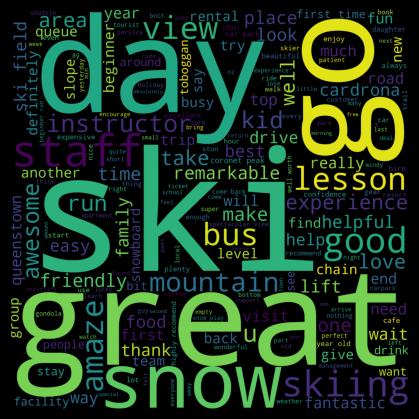

In [181]:
text = df_all['processed_review_text'].values
wordcloud = WordCloud(width=1500, height=1500, background_color='black', stopwords=STOPWORDS).generate(str(text))
fig = plt.figure(figsize=(4,4), facecolor='k', edgecolor='k')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

FIELD_1


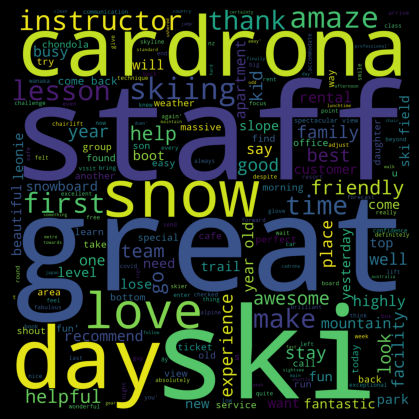

FIELD_2


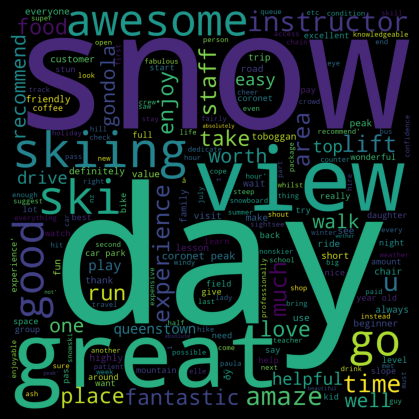

FIELD_3


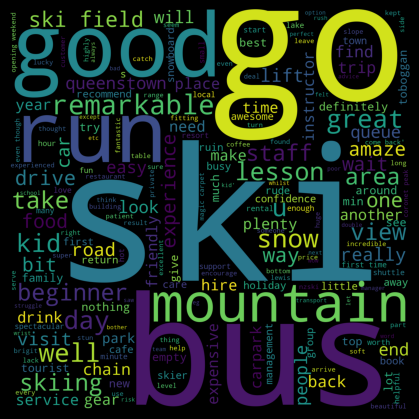

In [180]:
for source in df_all['source'].unique():
    print(source.upper())
    text = df_all[df_all['source'] == source]['processed_review_text'].values
    wordcloud = WordCloud(width=1500, height=1500, background_color='black', stopwords=STOPWORDS).generate(str(text))
    fig = plt.figure(figsize=(4,4), facecolor='k', edgecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

### Distribution of words and characters (overall and by field)

Text(0.5, 0, 'Number of words in review')

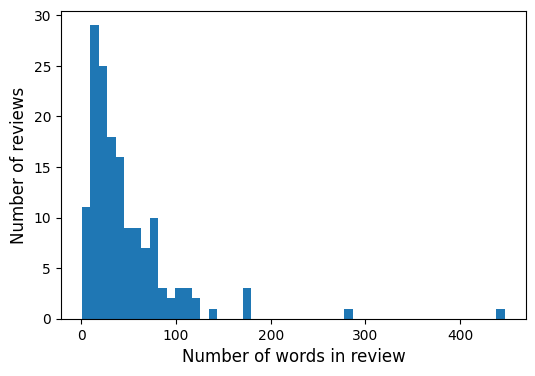

In [188]:
word_count = df_all['processed_review_text'].apply(lambda x: len(str(x).split()))
ax = word_count.plot(kind='hist', bins=50, fontsize=10, figsize=(6, 4))
ax.set_ylabel('Number of reviews', fontsize=12)
ax.set_xlabel('Number of words in review', fontsize=12)

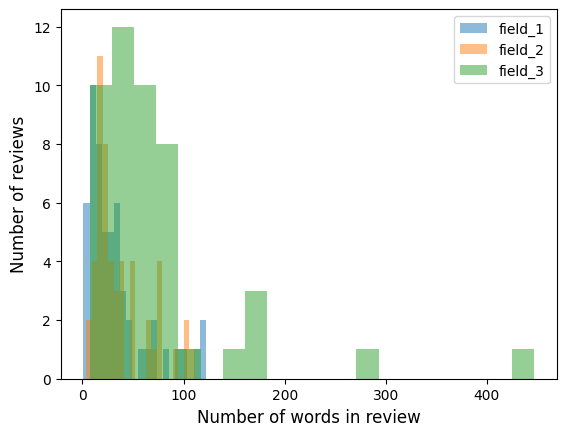

In [189]:
for source in df_all['source'].unique():
    word_count = df_all[df_all['source'] == source]['processed_review_text'].apply(lambda x: len(str(x).split()))
    plt.hist(word_count, bins=20, alpha=0.5, label=source)
plt.ylabel('Number of reviews', fontsize=12)
plt.xlabel('Number of words in review', fontsize=12)
plt.legend(loc='upper right')

Text(0.5, 0, 'Number of characters in review')

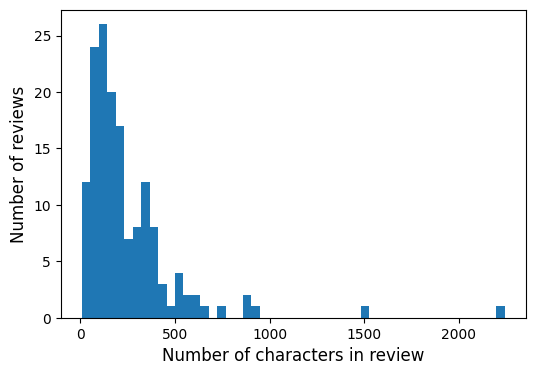

In [174]:
word_count = df_all['processed_review_text'].astype(str).apply(len)
ax = word_count.plot(kind='hist', bins=50, fontsize=10, figsize=(6, 4))
ax.set_ylabel('Number of reviews', fontsize=12)
ax.set_xlabel('Number of characters in review', fontsize=12)

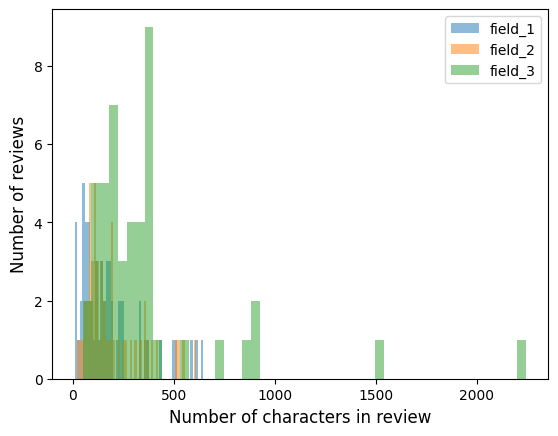

In [191]:
for source in df_all['source'].unique():
    word_count = df_all[df_all['source'] == source]['processed_review_text'].astype(str).apply(len)
    plt.hist(word_count, bins=50, alpha=0.5, label=source)
plt.ylabel('Number of reviews', fontsize=12)
plt.xlabel('Number of characters in review', fontsize=12)
plt.legend(loc='upper right')

### Most common words (after full stopword removal)

In [192]:
def remove_all_stopwords(text):
    stops = stopwords.words('english')
    tokens = [word for word in text.split() if word not in stops]
    return ' '.join(tokens)

In [175]:
fdist = FreqDist()
processed_review_text_wo_stopwords = df_all['processed_review_text'].apply(lambda x: remove_all_stopwords(x))

for text in processed_review_text_wo_stopwords:
    text_list = text.split()
    for word in text_list:
        fdist[word.lower()] += 1
most_common = fdist.most_common(20)

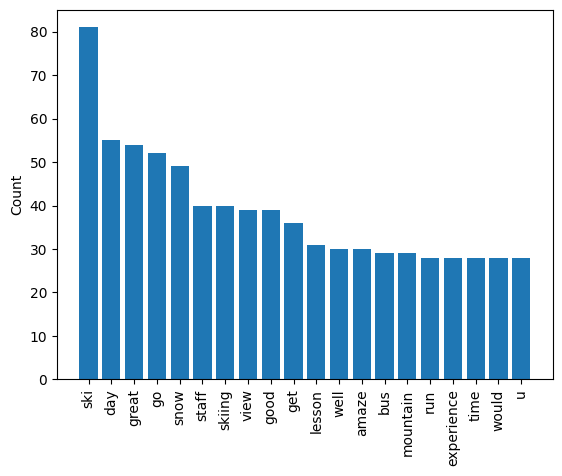

In [176]:
words, count = list(zip(*most_common))
x_pos = np.arange(len(words)) 
plt.bar(x_pos, count, align='center')
plt.xticks(x_pos, words, rotation=90) 
plt.ylabel('Count')
plt.show()

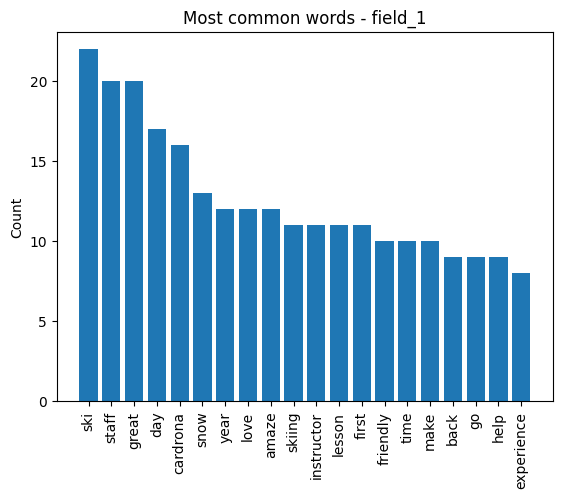

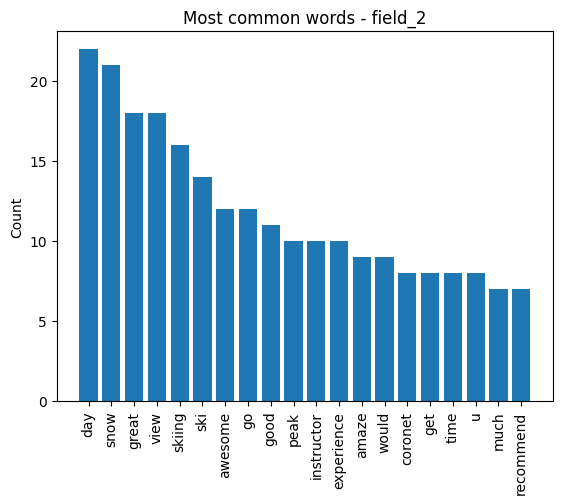

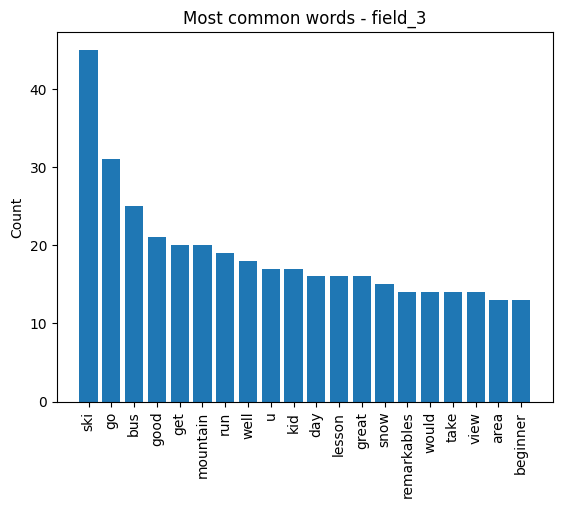

In [193]:
for source in df_all['source'].unique():
    fdist = FreqDist()
    for text in df_all[df_all['source'] == source]['processed_review_text'].apply(lambda x: remove_all_stopwords(x)):
        text_list = text.split()
        for word in text_list:
            fdist[word.lower()] += 1
    most_common = fdist.most_common(20)
    words, count = list(zip(*most_common))
    x_pos = np.arange(len(words)) 
    plt.bar(x_pos, count, align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.ylabel('Count')
    plt.title(f'Most common words - {source}')
    plt.show()

### TF-IDF

Term Frequency - Inverse Document Frequency (TF-IDF) is an NLP statistical technique to measure the importance of a term (consisting of one or more words) within a document (in this case, an individual review) relative to a collection of documents (in this case, all the reviews collected for this project).

A vectorizer is applied to the documents to calculate term frequency and inverse document frequency, and the output is a matrix with the rows being the documents (i.e. reviews) and columns being the unique terms across the entire collection, and the value in each row and column being the TF-IDF score for a particular term in a particular document (if a term is not present within a document, the score will be 0).

As this pertains to identifying underlying topics, we are using the text that has had all stopwords removed to reduce the number of terms on which the vectorizer needs to be applied.

In [194]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', ngram_range=(1,2), lowercase=False)  
matrix = vectorizer.fit_transform(processed_review_text_wo_stopwords)
tfidf_df = pd.DataFrame(matrix.toarray(), index=['review '+str(i) for i in range(1, 1+len(processed_review_text_wo_stopwords))], columns=vectorizer.get_feature_names_out())
tfidf_df.tail()

,aatkings,aatkings around,aatkings view,ability,ability appropriate,ability level,able,able get,able help,able walk,...,yesterday claire,yesterday first,yesterday full,yesterday staff,yesterday today,young,young kid,zealand,zealand good,zealander
review 149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
review 150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
review 151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
review 152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
review 153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# Creating a dictionary mapping the tokens to their tfidf scores
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

tfidf_scores_df = pd.DataFrame().from_dict(tfidf_scores, orient='index')
tfidf_scores_df.columns = ['tfidf_score']
tfidf_scores_df.head(20)

,tfidf_score
aatkings,4.938340
aatkings around,5.343805
aatkings view,5.343805
ability,4.938340
ability appropriate,5.343805
ability level,5.343805
able,4.650658
able get,5.343805
able help,5.343805
able walk,5.343805


Text(0, 0.5, 'Number of Words')

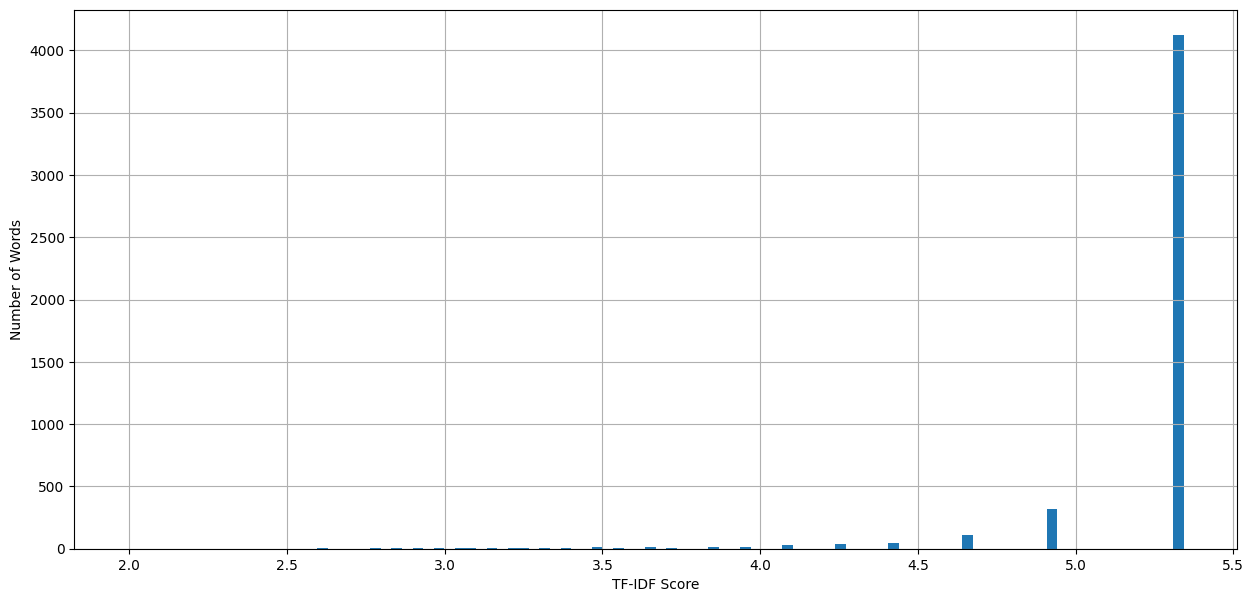

In [198]:
# Visualizing the distribution of the tfidf scores
tfidf_scores_df.tfidf_score.hist(bins=100, figsize=(15,7))
plt.xlabel('TF-IDF Score')
plt.ylabel('Number of Words')

As this is only an extract of the original dataset used, the exact scores vary, however the trend remains the same - the vast majority of terms have a single score.

#### Tokens with the lowest and highest TF-IDF scores

In [199]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

LOWEST TF-IDF SCORES


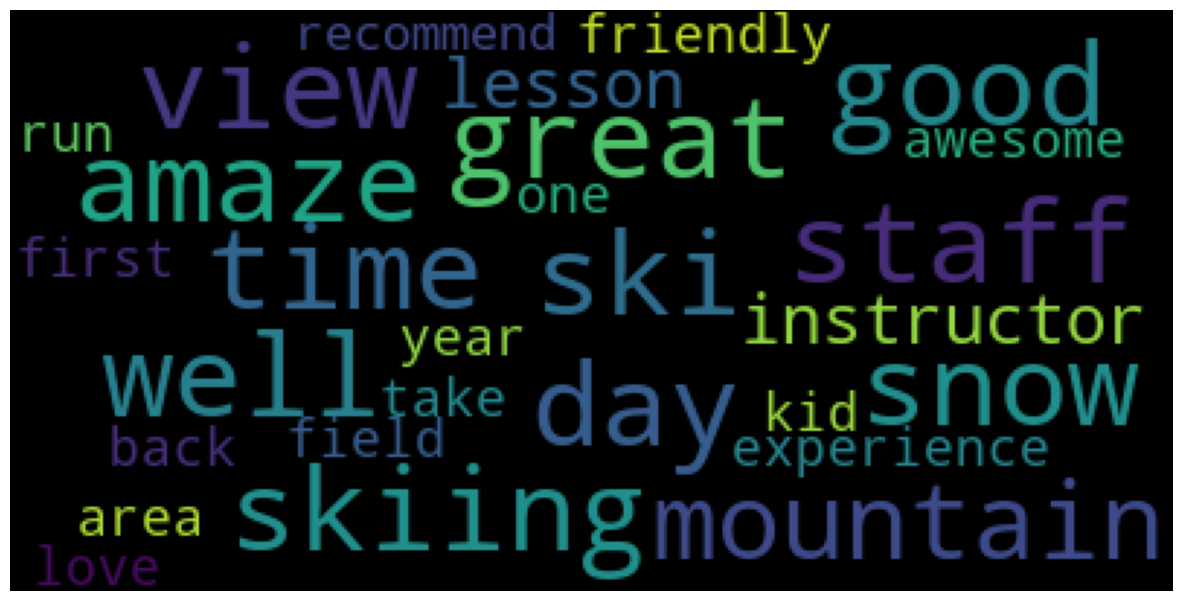

In [202]:
print("LOWEST TF-IDF SCORES")
plot_word_cloud(tfidf_scores_df.sort_values(by=['tfidf_score'], ascending=True).head(30))

HIGHEST TF-IDF SCORES


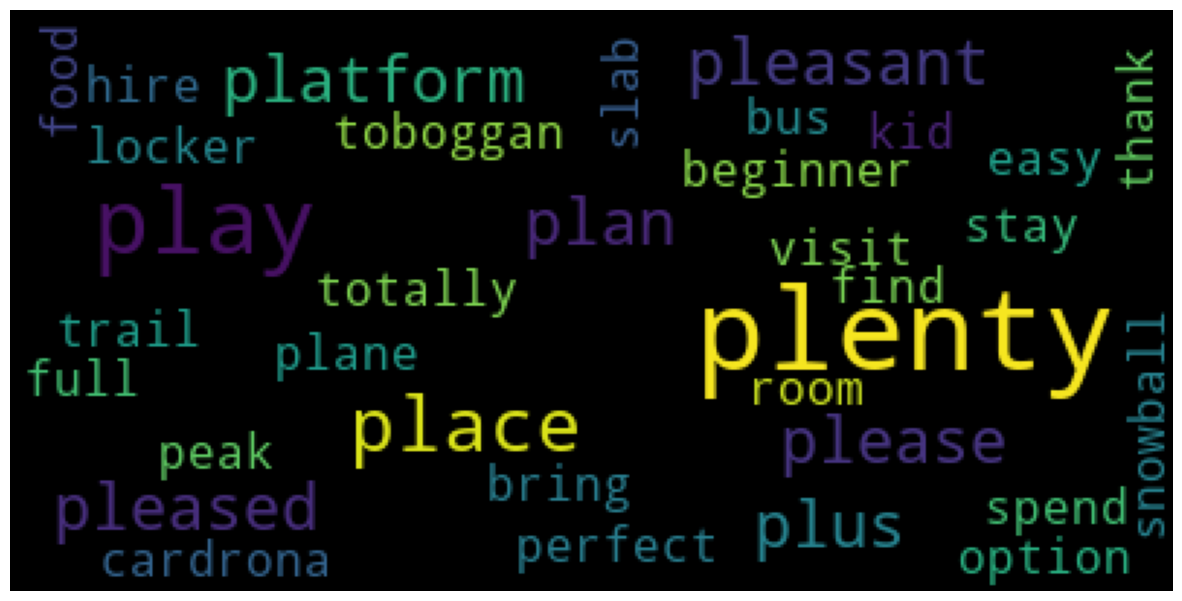

In [203]:
print("HIGHEST TF-IDF SCORES")
plot_word_cloud(tfidf_scores_df.sort_values(by=['tfidf_score'], ascending=False).head(30))

#### Plotting the most common bigrams and trigrams

Text(0.5, 1.0, 'Most common bigrams')

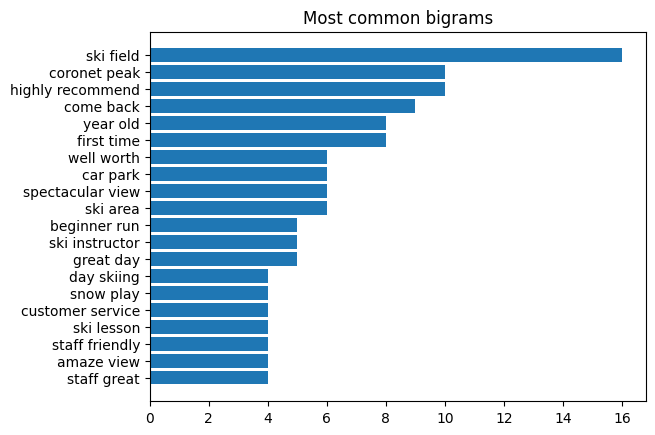

In [206]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', ngram_range=(2,2), lowercase=False)  
matrix = vectorizer.fit_transform(processed_review_text_wo_stopwords)
tfidf_df = pd.DataFrame(matrix.toarray(), index=['review '+str(i) for i in range(1, 1+len(processed_review_text_wo_stopwords))], columns=vectorizer.get_feature_names_out())

bigram_count = tfidf_df.astype(bool).sum(axis=0)
bigram_plotted = bigram_count.sort_values(ascending=False).head(20)

plt.barh(bigram_plotted.index[-1::-1], bigram_plotted.values[-1::-1])
plt.title("Most common bigrams")

Text(0.5, 1.0, 'Most common trigrams')

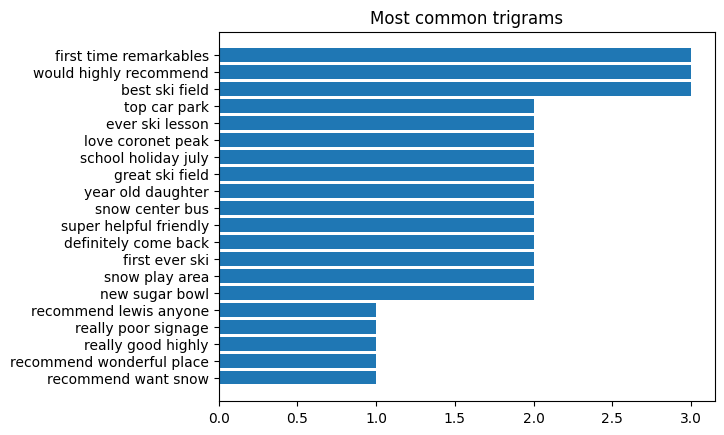

In [208]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', ngram_range=(3,3), lowercase=False)  
matrix = vectorizer.fit_transform(processed_review_text_wo_stopwords)
tfidf_df = pd.DataFrame(matrix.toarray(), index=['review '+str(i) for i in range(1, 1+len(processed_review_text_wo_stopwords))], columns=vectorizer.get_feature_names_out())

trigram_count = tfidf_df.astype(bool).sum(axis=0)
trigram_plotted = trigram_count.sort_values(ascending=False).head(20)

plt.barh(trigram_plotted.index[-1::-1], trigram_plotted.values[-1::-1])
plt.title("Most common trigrams")

In [1]:
processed_review_text_wo_stopwords

NameError: name 'processed_review_text_wo_stopwords' is not defined